In [17]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, BatchNormalization
from keras.models import Model
from keras.utils import get_custom_objects
import keras.backend as K

from IPython.display import display
import pandas as pd
import numpy as np
import os
from random import shuffle
from IPython.display import display
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt


# load data

In [18]:
# a=pd.DataFrame({'movie':[1,1,1,1,1],'user':[1,1,1,2,2],'rating':[1,2,-5,1,9]})
# display(a)
# a.groupby(['movie', 'user'])["rating"].sum().reset_index()


In [19]:
path=os.path.join('.','dataset','nba.pickle')
data=pd.read_pickle(path)
data.head(1)

,push_id,is_push,push_author,push_dt,train_or_test,content,label,article_id,push_num,title,href,article_author,article_dt
0,1,推,RazaviSmith,2019-06-08 23:03:00.000000,train,我也覺得勇士會拿下G5,1,1560006190,14,[討論] 接下來勇士會觸底反彈吧 Win or Go Home,www.ptt.cc/bbs/NBA/M.1560006190.A.408.html,Metaphor,2019-06-08


In [20]:
# columns=['article_id','push_author','label']
# data2=data[columns].copy()
# data2['label']=data2['label'].apply(lambda x: -1 if x==0 else 1)
# data2=data2.sort_values(by=['article_id','push_author'])
# data2

def change_label(data):
    columns=['article_id','push_author','label']
    data2=data[columns].copy()
    data2['label']=data2['label'].apply(lambda x: -1 if x==0 else 1)
    data2=data2.sort_values(by=['article_id','push_author'])
    
    data2=data2.groupby(['article_id', 'push_author'])["label"].sum().reset_index()
    data2=data2.rename(columns={'label':'rating'})
    
    return data2

data2=change_label(data)
data2.head(5)

,article_id,push_author,rating
0,1554601416,Acetoxy,1
1,1554601416,Bainite,1
2,1554601416,BlackHaoHow,1
3,1554601416,Blazeleo819,1
4,1554601416,BruceChen227,2


In [21]:
print(data2.shape)
print(data2.article_id.unique().shape)
print(data2.push_author.unique().shape)

(3631, 3)
(48,)
(2058,)


In [22]:
# users=pd.DataFrame({'push_author':data2.push_author.unique()})
# users['userID']=users.index

# articles=pd.DataFrame({'article_id':data2.article_id.unique()})
# articles['articleID']=articles.index

def get_users_articles(data2):
    users=pd.DataFrame({'push_author':data2.push_author.unique()})
    users['userID']=users.index

    articles=pd.DataFrame({'article_id':data2.article_id.unique()})
    articles['articleID']=articles.index

    return users,articles

users,articles=get_users_articles(data2)

In [23]:
# a=np.array([1.0,2,3])
# print(preprocessing.scale(a))
# mean=np.mean(a)
# std=np.std(a)
# print((a-mean)/std)

In [24]:
# data3=pd.merge(left=data2,right=users, how='left', on='push_author')
# data3=pd.merge(left=data3,right=articles, how='left', on='article_id')
# data3=data3.sort_values(by=['userID'],ascending=True)
# data3=data3[['userID','articleID','rating']].reset_index(drop=True)
# data3

# a = np.array([-3,-2,-1,0,1,2,3])
# np.clip(a, -2, 2)

# bound=3
# rating_clip=np.clip(data_all['rating'].values, -bound, bound)  
# data_all['rating_clip']=rating_clip
# data_all['rating_shift']=data_all['rating_clip'].apply(lambda x: x+bound)
# data_all.rating_shift.min()

def get_data_all(data2,users,articles):
    data3=pd.merge(left=data2,right=users, how='left', on='push_author')
    data3=pd.merge(left=data3,right=articles, how='left', on='article_id')
    data3=data3.sort_values(by=['userID'],ascending=True)
    data3=data3[['userID','articleID','rating']].reset_index(drop=True)
    
    bound=3
    rating_clip=np.clip(data3['rating'].values, -bound, bound)  
    data3['rating_clip']=rating_clip
    data3['rating_shift']=data3['rating_clip'].apply(lambda x: x+bound)
    return data3

data_all=get_data_all(data2,users,articles)
print('min',data_all.rating_shift.min())
print('max',data_all.rating_shift.max())
data_all.tail()


min 1
max 6


,userID,articleID,rating,rating_clip,rating_shift
3626,2053,46,1,1,4
3627,2054,46,0,0,3
3628,2055,47,2,2,5
3629,2056,47,1,1,4
3630,2057,47,1,1,4


In [25]:
# def normalize_rating(data_all):
#     arr=data_all.rating.values
#     rating_mean=np.mean(arr)
#     rating_std=np.std(arr)
#     rating_norm=(arr-rating_mean)/rating_std
#     data_all['rating_norm']=rating_norm
#     return data_all,rating_mean,rating_std

# data_norm,rating_mean,rating_std=normalize_rating(data_all)
# print(rating_mean,rating_std)
# data_norm.head()

In [26]:
# arr = np.arange(10)
# shuffle(arr)
# ratio=0.2
# valid_num=int(len(arr)*ratio)
# index_valid=arr[:valid_num]
# index_train=arr[valid_num:]
# print(index_valid,index_train)

def get_index_train_valid(n=10,ratio=0.2):
    arr = np.arange(n)
    shuffle(arr)
    valid_num=int(len(arr)*ratio)
    index_valid=arr[:valid_num]
    index_train=arr[valid_num:]
    return (index_valid,index_train)

index_valid,index_train=get_index_train_valid(n=10,ratio=0.3)
print(index_valid,index_train)

[0 1 2] [3 4 5 6 7 8 9]


In [27]:
# index_valid,index_train=get_index_train_valid(n=len(data_all),ratio=0.1)
# data_train=data_all.iloc[index_train].reset_index(drop=True)
# data_valid=data_all.iloc[index_valid].reset_index(drop=True)
# data_valid

def get_data_train_valid(data_all):
    index_valid,index_train=get_index_train_valid(n=len(data_all),ratio=0.1)
    data_train=data_all.iloc[index_train].reset_index(drop=True)
    data_valid=data_all.iloc[index_valid].reset_index(drop=True)
    return data_train,data_valid

data_train,data_valid=get_data_train_valid(data_all)
print(len(data_all),len(data_train),len(data_valid))
print(data_all.userID.unique().shape,data_all.articleID.unique().shape)
print(data_train.userID.unique().shape,data_train.articleID.unique().shape)
display(data_train.head())
display(data_valid.head())

3631 3268 363
(2058,) (48,)
(1853,) (47,)


,userID,articleID,rating,rating_clip,rating_shift
0,205,17,5,3,6
1,205,30,1,1,4
2,205,42,1,1,4
3,205,13,-1,-1,2
4,205,12,1,1,4


,userID,articleID,rating,rating_clip,rating_shift
0,0,0,1,1,4
1,1,0,1,1,4
2,2,0,1,1,4
3,3,0,1,1,4
4,3,42,1,1,4


# model

In [28]:
def rmse(y_true, y_pred):
    y_pred = K.clip(y_pred, 0.0, 6.0)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))
get_custom_objects().update({"rmse": rmse})


In [29]:
input_length=1
n_users=3
n_movies=8
latent_dim=20

user_input = Input(shape=(input_length,))
movie_input = Input(shape=(input_length,))

user_vecter = Embedding(input_dim=n_users, output_dim=latent_dim, input_length=input_length, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)

movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)


rating_predict = dot([user_vecter,movie_vecter],axes=1)

model = Model([user_input,movie_input],rating_predict)

model.compile(loss="mse", optimizer="adam", metrics=[rmse])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 20)        60          input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 20)        160         input_4[0][0]                    
__________________________________________________________________________________________________
flatten_3 

In [30]:
x_train=[data_train.userID.values,data_train.articleID.values]
y_train=[data_train.rating.values]
x_valid=[data_valid.userID.values,data_valid.articleID.values]

# y_valid=[data_valid.rating.values]
y_valid=[data_valid.rating_shift.values]



In [31]:
# https://www.youtube.com/watch?v=BZh1ltr5Rkg
# https://stackoverflow.com/questions/47312219/what-does-non-trainable-params-mean

epochs=5
batch_size=10
history = model.fit(x_train,y_train,
                    validation_data=(x_valid,y_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1, 
                    shuffle=True,
                    )

Train on 3268 samples, validate on 363 samples
Epoch 1/5
3268/3268 [==============================] - 1s 429us/step - loss: 4.1591 - rmse: 1.6132 - val_loss: 16.6503 - val_rmse: 4.0700
Epoch 2/5
3268/3268 [==============================] - 1s 252us/step - loss: 4.1591 - rmse: 1.6281 - val_loss: 16.6503 - val_rmse: 4.0700
Epoch 3/5
3268/3268 [==============================] - 1s 262us/step - loss: 4.1591 - rmse: 1.6299 - val_loss: 16.6503 - val_rmse: 4.0700
Epoch 4/5
3268/3268 [==============================] - 1s 252us/step - loss: 4.1591 - rmse: 1.6195 - val_loss: 16.6503 - val_rmse: 4.0700
Epoch 5/5
3268/3268 [==============================] - 1s 269us/step - loss: 4.1591 - rmse: 1.6370 - val_loss: 16.6503 - val_rmse: 4.0700


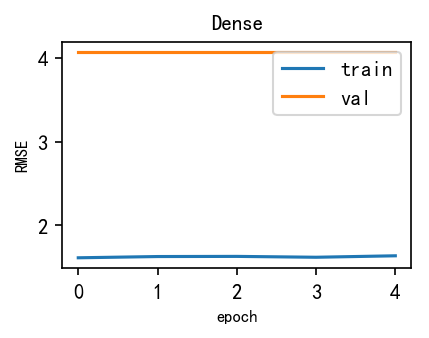

In [32]:
def plot_history(history):
    plt.figure(figsize=(3,2), dpi=150)
    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('Dense', fontsize=10)
    plt.ylabel('RMSE', fontsize=8)
    plt.xlabel('epoch', fontsize=8)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history)